In [131]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import shap
import datetime
from sklearn import preprocessing

In [132]:
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL_new_r0_chile.csv')
del df['Unnamed: 0']
df=df[['Code', 'Date', 'contact_tracing', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'Holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
      'total_vaccinations_per_100', '%youth_unemployment_total','excess_mortality',
      'accumulated', 'reproduction_rate']]
df = df.rename(columns={'excess_mortality': 'infected_rate'})

df['temp'] = df.apply(
    lambda row: df[pd.to_datetime(df['Date']).dt.month==pd.to_datetime(row['Date']).month]['temp'].iloc[0] if np.isnan(row['temp']) else row['temp'],
    axis=1
)
df=df[[c for c in df if c not in ['reproduction_rate']] 
       + ['reproduction_rate']]
df[df['infected_rate'] <= 0]['infected_rate'] = 0
#df=df[df['reproduction_rate']<2.5]
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Code,Date,contact_tracing,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,...,Holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,infected_rate,accumulated,reproduction_rate
0,AUS,2020-03-29,2.0,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,0.000000,...,0.0,21.346512,0.142010,8263000.0,85.904,NaN,11.84,11.31,0.002310,2.170000
1,AUS,2020-04-05,2.0,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,0.000000,...,0.0,21.176835,0.054789,8263000.0,85.904,NaN,11.84,6.36,0.003046,2.330000
2,AUS,2020-04-12,2.0,-10.591857,22.020286,5.102143,-21.836714,-14.836714,-0.918286,0.285714,...,0.0,20.702945,0.051898,8263000.0,85.904,NaN,11.84,2.95,0.004272,2.280000
3,AUS,2020-04-19,2.0,-32.163429,-0.020429,13.428429,-48.775571,-28.183714,-22.816286,2.000000,...,0.0,21.093375,0.073336,8263000.0,85.904,NaN,11.84,5.75,0.005416,1.457143
4,AUS,2020-04-26,2.0,-40.918429,-12.347143,17.612143,-60.204143,-39.326571,-35.265286,2.000000,...,0.0,18.880697,0.118556,8263000.0,85.904,NaN,11.84,3.18,0.006059,0.765714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3581,USA,2021-04-11,1.0,-8.816429,-4.244714,7.040714,-27.183571,4.265286,-25.775714,1.000000,...,0.0,7.624732,0.073711,75608000.0,82.058,36.955714,8.30,NaN,0.239634,1.021429
3582,USA,2021-04-18,1.0,-8.469429,-4.000143,6.632286,-26.163143,12.040857,-24.877429,1.000000,...,0.0,10.027194,0.090106,75608000.0,82.058,42.600000,8.30,NaN,0.239634,1.074286
3583,USA,2021-04-25,1.0,-8.020429,-0.142857,6.449143,-25.469286,17.755000,-27.979714,1.000000,...,0.0,21.176835,NaN,75608000.0,82.058,48.920000,8.30,NaN,0.239634,1.047143
3584,USA,2021-05-02,1.0,-7.979571,-1.816286,5.816143,-24.571429,24.347000,-26.428571,1.000000,...,0.0,19.355421,NaN,75608000.0,82.058,55.571429,8.30,NaN,0.239634,1.042857


In [133]:
df_appch2=df.copy()

In [134]:
#We define bad mobility as the weighted average of mobility trends that have a positive impact on covid spread
df_appch2['bad_mobility']=(df_appch2['retail_and_recreation']*0.4+df_appch2['transit_stations']*0.2
                           +df_appch2['grocery_and_pharmacy']*0.2+df_appch2['workplaces']*0.2)

#We define good mobility as the weighted average of mobility trends that have a negative impact on covid spread
df_appch2['good_mobility']=(df_appch2['residential']*0.6+df_appch2['parks']*0.4)

df_appch2['awareness_measures'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8

df_appch2['government_economic_measures']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['health_measures']=df_appch2['contact_tracing']*0.5+df_appch2['testing_policy']*0.5
df_appch2['mobility_measures']=df_appch2['stay_home_requirements'] + df_appch2['restriction_gatherings']\
                               +df_appch2['cancel_public_events'] + df_appch2['restrictions_internal_movements']\
                               +df_appch2['international_travel_controls'] + df_appch2['close_public_transport']\
                               +df_appch2['workplace_closures']+df_appch2['school_closures']

df_appch2=df_appch2[['Code', 'Date','bad_mobility', 'good_mobility', 
                    'government_economic_measures', 'health_measures',
                     'mobility_measures', 'Holiday', 'temp', 'prcp', 
                     'number_of_arrivals', 'urban_population',
                       'total_vaccinations_per_100', '%youth_unemployment_total',
                       'infected_rate', 'accumulated', 'reproduction_rate']]
df_appch2_clean=df_appch2.copy()
df_appch2_clean = df_appch2_clean[df_appch2_clean['bad_mobility'].notna()]
df_appch2_clean = df_appch2_clean[df_appch2_clean['good_mobility'].notna()]
#df_appch2_clean['temp'] = df_appch2_clean['temp'].fillna(df_appch2_clean['temp'].mean())
df_appch2_clean['prcp'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['number_of_arrivals'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['urban_population'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['total_vaccinations_per_100'] = df_appch2_clean['total_vaccinations_per_100'].fillna(0)
df_appch2_clean['%youth_unemployment_total']= df_appch2_clean['%youth_unemployment_total'].fillna(df_appch2_clean['%youth_unemployment_total'].mean())
df_appch2_clean = df_appch2_clean[df_appch2_clean['infected_rate'].notna()]
df_appch2_clean['accumulated']= df_appch2_clean['accumulated'].fillna(df_appch2_clean['accumulated'].mean())

In [161]:
date=pd.Timestamp(2021, 1, 10)
X_1_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) <= date)]
X_2_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) > date)]
scaler = preprocessing.StandardScaler().fit(df_appch2_clean[df_appch2_clean.columns[2:-1]])

X_train_appch2_clean = pd.DataFrame(scaler.transform(X_1_clean[X_1_clean.columns[2:-1]]), columns=df_appch2_clean.columns[2:-1])
X_test_appch2_clean = pd.DataFrame(scaler.transform(X_2_clean[X_1_clean.columns[2:-1]]), columns=df_appch2_clean.columns[2:-1])

y_train_appch2_clean=X_1_clean['reproduction_rate']
y_test_appch2_clean=X_2_clean['reproduction_rate']

In [162]:
reg2_gbr = GradientBoostingRegressor()
reg2_gbr.fit(X_train_appch2_clean, y_train_appch2_clean)
y_pred_2=reg2_gbr.predict(X_test_appch2_clean)
y_pred_train_2=reg2_gbr.predict(X_train_appch2_clean)

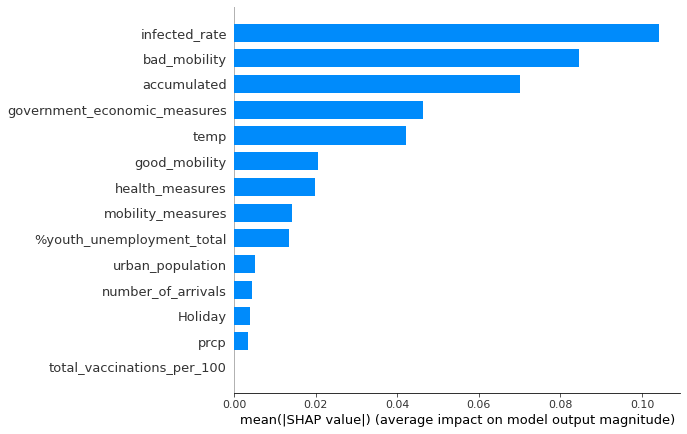

In [163]:
shap_values = shap.TreeExplainer(reg2_gbr).shap_values(X_train_appch2_clean)
shap.summary_plot(shap_values, X_train_appch2_clean, plot_type="bar")

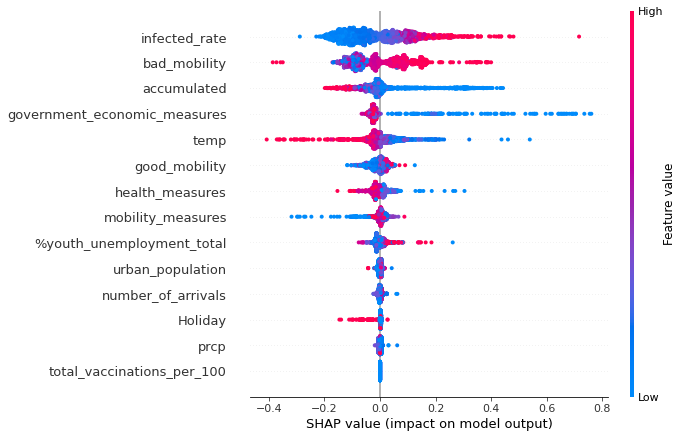

In [177]:
explainer = shap.TreeExplainer(reg2_gbr)
shap_values = explainer.shap_values(X_train_appch2_clean)
shap.summary_plot(shap_values, X_train_appch2_clean)

In [178]:
df_appch2.columns

Index(['Code', 'Date', 'bad_mobility', 'good_mobility',
       'government_economic_measures', 'health_measures', 'mobility_measures',
       'Holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', '%youth_unemployment_total',
       'infected_rate', 'accumulated', 'reproduction_rate'],
      dtype='object')

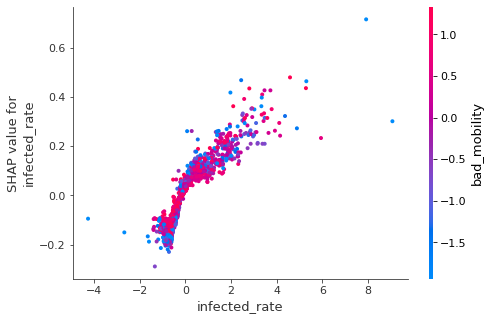

In [179]:
shap.dependence_plot("infected_rate", shap_values, X_train_appch2_clean)

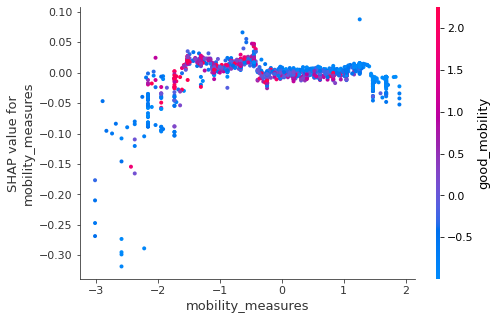

In [180]:
shap.dependence_plot("mobility_measures", shap_values, X_train_appch2_clean)

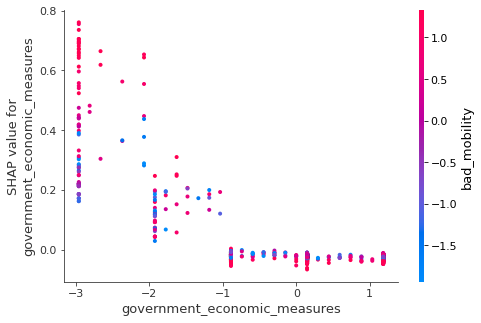

In [181]:
shap.dependence_plot("government_economic_measures", shap_values, X_train_appch2_clean)

In [195]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(reg2_gbr)
    shap_values_Model = explainerModel.shap_values(X_train_appch2_clean)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_train_appch2_clean.iloc[[j]])
    return(p)

In [196]:
shap_plot(0)

In [198]:
shap_plot(1)

In [200]:
shap_plot(10)